# Сверточные нейросети

Слой сверточной сети состоит из ядра - окна с весами, которое последовательно проходит по пикселям входящего изображения (на картинке движется ядро размером  3x3 ) и складывает их с соответствующими весами.

Таким образом, использование сверток помогает извлекать паттерны на картинке.
Чем глубже сверточный слой, тем более сложные паттерны он способен распознавать.

#### MaxPool

Слой, похожий на свертку, но вместо суммирования элементов входного изображения с весами ядра, этот слой внутри перемещающегося окна выбирает максимальный элемент и передает его дальше.

Обычно слои **Conv** и **MaxPool** используют в паре, **MaxPool** используется для уменьшения размерности данных.

Теперь вместо того, чтобы превращать нашу картинку в вектор (из-за чего мы теряем много информации о взаимном расположении пикселей) и отправлять на вход Dense слоям, сначала мы произведем свертку изображения при помощи Conv2D.

Таким образом мы постараемся извлечь основные паттерны одежды, и только потом результат свертки превратим в вектор и передадим его полносвязной части нейросети.

In [1]:
# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

### 1. Загрузка данных

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 2. Подготовка данных 

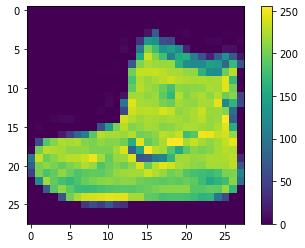

In [4]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

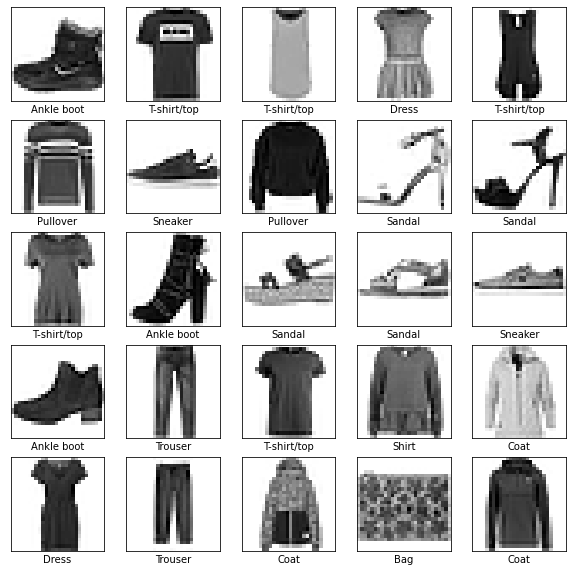

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [7]:
w, h = 28, 28
train_images = train_images.reshape(train_images.shape[0], w, h, 1)
test_images = test_images.reshape(test_images.shape[0], w, h, 1)

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

### 3. Создание модели для обучения

In [8]:
from keras.layers.convolutional import Conv2D

In [9]:
model = keras.Sequential()

In [10]:
# В начале добавляем сверточный слой, первый параметр - количество фильров (64),
# второй - размер "ядра" - окошка, перемещающегося по входному изображению 2,
# padding - добавление пикселей по краям изображения, чтобы сделать свертку на 
# крайних пикселях, режим `same` - повторение края
# активация - используемая функция активации, в данном случае relu; input_shape - это форма изображения, представленного в CNN: в нашем случае это 28 x 28.
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
# MaxPooling2D - это операция максимального объединения пространственных данных. Здесь используются следующие параметры:
# pool_size, в данном случае 2, представляющий коэффициенты для уменьшения масштаба в обоих направлениях;
model.add(keras.layers.MaxPooling2D(pool_size=2))
# Слой dropout, который на каждом шаге "выключает" 30% случайно выбранных нейронов
model.add(keras.layers.Dropout(0.3))
# Еще сверточный слой
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
# выбирая из 2 пикселей 1 с максимальным значением, чтобы это быстрее считалось.
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
# Разворачиваем результат свертки в вектор
model.add(keras.layers.Flatten())
# Добавляем полносвязный скрытый слой, вид активации можно указать сразу 
# в описании Dense слоя, в данном случае - ReLU
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
# Для выходного полносвязного слоя указываем количество итоговых классов и 
# softmax для активации
model.add(keras.layers.Dense(10, activation='softmax'))

In [11]:
# При помощи метода `summary` мы можем посмотреть,как выглядит наша 
# итоговая архитектура нейросети и количество параметров (весов)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [12]:
# compile модели
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Компилируем модель с функцией ошибки categorical entropy, оптимизатором Адам 
# (оптимизатор, который со стандартным набором параметров может обучить эффективную
#  нейросеть), и метрикой - количеством правильно угаданных цифр.

### 4. Обучение модели

In [13]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

model.fit(train_images, train_labels,
         batch_size=64,
         epochs=10,
         validation_data=(test_images, test_labels),
         callbacks=[checkpointer])

Epoch 1/10
937/938 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.7811
Epoch 00001: val_loss improved from inf to 0.38826, saving model to model.weights.best.hdf5
938/938 [==============================] - 42s 45ms/step - loss: 0.5917 - accuracy: 0.7812 - val_loss: 0.3883 - val_accuracy: 0.8624
Epoch 2/10
937/938 [============================>.] - ETA: 0s - loss: 0.4122 - accuracy: 0.8500
Epoch 00002: val_loss improved from 0.38826 to 0.33788, saving model to model.weights.best.hdf5
938/938 [==============================] - 45s 47ms/step - loss: 0.4122 - accuracy: 0.8500 - val_loss: 0.3379 - val_accuracy: 0.8767
Epoch 3/10
937/938 [============================>.] - ETA: 0s - loss: 0.3678 - accuracy: 0.8662
Epoch 00003: val_loss improved from 0.33788 to 0.31519, saving model to model.weights.best.hdf5
938/938 [==============================] - 45s 48ms/step - loss: 0.3678 - accuracy: 0.8662 - val_loss: 0.3152 - val_accuracy: 0.8858
Epoch 4/10
938/938 [=========

In [14]:
# Загрузить веса с максимальной точностью проверки
model.load_weights('model.weights.best.hdf5')

### 5. Валидация качества модели на тестовых данных.

In [15]:
# оценка точности
score = model.evaluate(test_images, test_labels, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9067999720573425


Что это означает: для нашей модели на основе нейронной сети мы получаем точность 91% - то есть, с вероятностью 91% модель определяет, какая цифра нарисована на картинке

### 6. Визуализация prediction

Теперь давайте визуализируем прогноз. 

#### Получение предсказаний классов на основе выходных данных нейросети

Как мы уже поняли, выходной слой нейросети возвращает нам вектор длиной $10$ (количество классов) с **вероятностями** принадлежности данного объекта каждому классу. Как же нам получить итоговые предсказания, то есть сами **номера классов**? 

Сначала мы получаем прогнозы с моделью из тестовых данных. 
Затем мы распечатываем 15 изображений из набора тестовых данных и устанавливаем заголовки с предсказанием (и меткой истинности). Если прогноз соответствует истинной метке, заголовок будет зеленым; в противном случае он отображается красным.

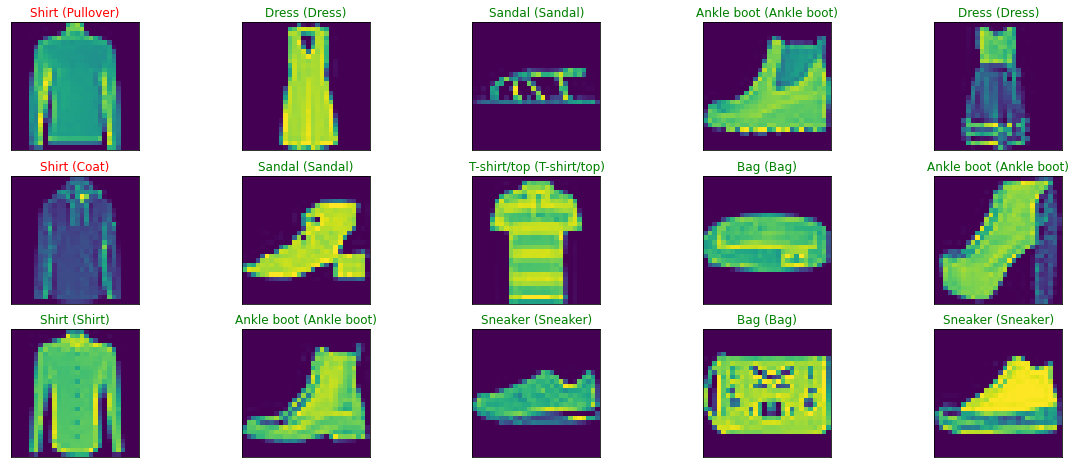

In [16]:
pred = model.predict(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(pred[index])
    true_index = np.argmax(test_labels[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))